In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from timezonefinder import TimezoneFinder
import pytz
from scipy import signal
import time
import random, os
from dotenv import load_dotenv

load_dotenv()
'''
# MAREA API parameters: 
https://api.target.ooo/v2/tides?duration=44640&timestamp=1709136000&interval=60&model=FES2014&station_id=TICON:e7648c61b8&datum=MSL&token=

# CWA API:
https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-B0075-002?Authorization=&StationID=C4B01&WeatherElement=TideHeight,TideLevel&sort=DataTime&timeFrom=2024-07-03T00%3A00%3A00

# NOAA API:
https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&begin_date=20240707&end_date=20240708&datum=MSL&station=8447930&time_zone=LST_LDT&units=metric&format=json&application=NOS.COOPS.TAC.COOPSMAP
'''

'\n# MAREA API parameters: \nhttps://api.target.ooo/v2/tides?duration=44640&timestamp=1709136000&interval=60&model=FES2014&station_id=TICON:e7648c61b8&datum=MSL&token=\n\n# CWA API:\nhttps://opendata.cwa.gov.tw/api/v1/rest/datastore/O-B0075-002?Authorization=&StationID=C4B01&WeatherElement=TideHeight,TideLevel&sort=DataTime&timeFrom=2024-07-03T00%3A00%3A00\n\n# NOAA API:\nhttps://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&begin_date=20240707&end_date=20240708&datum=MSL&station=8447930&time_zone=LST_LDT&units=metric&format=json&application=NOS.COOPS.TAC.COOPSMAP\n'

In [2]:
# Find timezone for NOAA 'LST_LDT'
def find_timezone(lon, lat):
    tf = TimezoneFinder()
    tz_str = tf.timezone_at(lng=lon, lat=lat)
    return tz_str

# Adjust the start date based on the station's time zone
def get_local_start_date(local_timezone=None, station_lon=None, station_lat=None):
    if local_timezone is None or not local_timezone:
        local_timezone = find_timezone(station_lon, station_lat)
        if not local_timezone:
            raise ValueError("Timezone not found for given coordinates: ", station_lon, station_lat)
    local_tz = pytz.timezone(local_timezone)
    now = datetime.now(local_tz) - timedelta(1)
    start_date = now.strftime('%Y-%m-%dT00:00:00')
    return start_date

# Convert UNIX timestamp to UTC datetime
def unix_to_utc(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp, timezone.utc).strftime('%Y-%m-%dT%H:%M:%S')

# Convert GMT+8 to UTC
def gmt8_to_utc(gmt8_datetime, tz=timezone.utc):
    gmt8_dt = datetime.strptime(gmt8_datetime, "%Y-%m-%dT%H:%M:%S%z")
    utc_dt = gmt8_dt.astimezone(tz) #pytz.timezone('Asia/Tokyo')) # 'US/Pacific'))
    return utc_dt.strftime('%Y-%m-%dT%H:%M:%S')

def local_to_utc(local_datetime, local_timezone='Asia/Taipei', tz=timezone.utc, format="%Y-%m-%dT%H:%M:%S%z"):
    #local_dt = datetime.strptime(local_datetime, format) # "%Y-%m-%d %H:%M"
    if not local_timezone:
        return datetime.strptime(local_datetime, '%Y-%m-%dT%H:%M:%S') # If timezone not found, return the local time
    local_tz = pytz.timezone(local_timezone) # pytz.timezone('Asia/Tokyo')) # 'US/Pacific'))
    local_dt = local_tz.localize(datetime.strptime(local_datetime, format))    
    utc_dt = local_dt.astimezone(tz) 
    return utc_dt.strftime('%Y-%m-%dT%H:%M:%S')

# Read Marea API response from JSON file
def read_marea_data(file_path):
    with open(file_path, 'r') as file:
        marea_data = json.load(file)
    return marea_data

# Read CWA API response from JSON file
def read_cwa_data(file_path):
    with open(file_path, 'r') as file:
        cwa_data = json.load(file)
    return cwa_data

# Extract heights from Marea data
def extract_marea_heights(marea_data):
    heights = pd.DataFrame(marea_data["heights"])
    heights["timestamp_utc"] = heights["timestamp"].apply(unix_to_utc)
    heights["timestamp_utc"] = pd.to_datetime(heights["timestamp_utc"])
    heights["height"] = heights["height"].astype(float)
    return heights

# Extract heights from CWA data
def extract_cwa_heights(cwa_data):
    records = cwa_data["Records"]["SeaSurfaceObs"]["Location"][0]["StationObsTimes"]["StationObsTime"]
    heights = []
    for record in records:
        if record["WeatherElements"]["TideHeight"] == 'None':
            continue
        dt_utc = gmt8_to_utc(record["DateTime"])
        height = float(record["WeatherElements"]["TideHeight"])
        heights.append({"timestamp_utc": dt_utc, "height": height})
    if not heights:  # Check if heights list is empty
        return pd.DataFrame()  # Return empty DataFrame
    heights_df = pd.DataFrame(heights)
    heights_df["timestamp_utc"] = pd.to_datetime(heights_df["timestamp_utc"])
    return heights_df

# Fetch data from Tide API
def fetch_tide_data(lon, lat, start, end):
    tide_url = f"https://eco.odb.ntu.edu.tw/api/tide?lon0={lon}&lat0={lat}&start={start}&end={end}"
    response = requests.get(tide_url)
    return response.json()


In [197]:
if True:
    marea_file_path = 'test_marea01_full.json'
    marea_data = read_marea_data(marea_file_path)
    marea_heights = extract_marea_heights(marea_data)
    
    # Determine the min/max timestamps from Marea data
    min_timestamp = marea_heights["timestamp_utc"].min()
    max_timestamp = marea_heights["timestamp_utc"].max()
        
    # Convert min/max timestamps to UTC (formatted string)
    start_utc = min_timestamp.strftime('%Y-%m-%dT%H:%M:%S')
    end_utc = (max_timestamp + timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%S')  # Ensure complete coverage
       
print("start/end: ", start_utc, end_utc)
print(marea_heights)

start/end:  2024-02-28T16:00:00 2024-03-31T15:00:00
      timestamp    height    state                   datetime  \
0    1709136000  0.098312   RISING  2024-02-28T16:00:00+00:00   
1    1709139600  0.078272  FALLING  2024-02-28T17:00:00+00:00   
2    1709143200  0.005280  FALLING  2024-02-28T18:00:00+00:00   
3    1709146800 -0.103258  FALLING  2024-02-28T19:00:00+00:00   
4    1709150400 -0.211453  FALLING  2024-02-28T20:00:00+00:00   
..          ...       ...      ...                        ...   
739  1711796400 -0.560957   RISING  2024-03-30T11:00:00+00:00   
740  1711800000 -0.509589   RISING  2024-03-30T12:00:00+00:00   
741  1711803600 -0.413487   RISING  2024-03-30T13:00:00+00:00   
742  1711807200 -0.285200   RISING  2024-03-30T14:00:00+00:00   
743  1711810800 -0.145741   RISING  2024-03-30T15:00:00+00:00   

          timestamp_utc  
0   2024-02-28 16:00:00  
1   2024-02-28 17:00:00  
2   2024-02-28 18:00:00  
3   2024-02-28 19:00:00  
4   2024-02-28 20:00:00  
..         

In [115]:
if True:
    # Fetch Tide API data
    lon, lat = 121.745, 25.1567
    tide_data30day = fetch_tide_data(lon, lat, start_utc, end_utc)

print(tide_data30day)    

{'longitude': [121.7333319581687], 'latitude': [25.16666766207122], 'time': ['2024-02-28T16:00:00', '2024-02-28T17:00:00', '2024-02-28T18:00:00', '2024-02-28T19:00:00', '2024-02-28T20:00:00', '2024-02-28T21:00:00', '2024-02-28T22:00:00', '2024-02-28T23:00:00', '2024-02-29T00:00:00', '2024-02-29T01:00:00', '2024-02-29T02:00:00', '2024-02-29T03:00:00', '2024-02-29T04:00:00', '2024-02-29T05:00:00', '2024-02-29T06:00:00', '2024-02-29T07:00:00', '2024-02-29T08:00:00', '2024-02-29T09:00:00', '2024-02-29T10:00:00', '2024-02-29T11:00:00', '2024-02-29T12:00:00', '2024-02-29T13:00:00', '2024-02-29T14:00:00', '2024-02-29T15:00:00', '2024-02-29T16:00:00', '2024-02-29T17:00:00', '2024-02-29T18:00:00', '2024-02-29T19:00:00', '2024-02-29T20:00:00', '2024-02-29T21:00:00', '2024-02-29T22:00:00', '2024-02-29T23:00:00', '2024-03-01T00:00:00', '2024-03-01T01:00:00', '2024-03-01T02:00:00', '2024-03-01T03:00:00', '2024-03-01T04:00:00', '2024-03-01T05:00:00', '2024-03-01T06:00:00', '2024-03-01T07:00:00', '20

In [3]:
# Filter overlapping time ranges and compare
def filter_and_compare(target_df, tide_df):
    # Filter data based on overlapping time ranges
    min_time = max(target_df["timestamp_utc"].min(), tide_df["timestamp"].min())
    max_time = min(target_df["timestamp_utc"].max(), tide_df["timestamp"].max())
    
    target_filtered = target_df[(target_df["timestamp_utc"] >= min_time) & (target_df["timestamp_utc"] <= max_time)]
    tide_filtered = tide_df[(tide_df["timestamp"] >= min_time) & (tide_df["timestamp"] <= max_time)]
    
    # Interpolate ODB data to match Marea timestamps
    odb_interpolated = tide_filtered.set_index('timestamp').reindex(target_filtered['timestamp_utc']).interpolate()
    
    comparison_df = pd.DataFrame({
        "timestamp_utc": target_filtered['timestamp_utc'],
        "height_target": target_filtered['height'],
        "height_tide": odb_interpolated['height'].values
    })
    comparison_df["height_diff"] = comparison_df["height_target"] - comparison_df["height_tide"]
    
    return comparison_df

# Calculate phase difference using cross-correlation
def calculate_phase_difference(signal1, signal2):
    correlation = signal.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lags = signal.correlation_lags(len(signal1), len(signal2), mode='full')
    lag = lags[np.argmax(correlation)]
    return lag

In [199]:
# Filter and compare data
# Extract heights from Tide API
tide_times = pd.to_datetime(tide_data30day["time"])
tide_heights = np.array(tide_data30day["z"]) / 100  # Convert cm to m
tide_df30day = pd.DataFrame({"timestamp": tide_times, "height": tide_heights})
comparison_marea = filter_and_compare(marea_heights, tide_df30day)
print(comparison_marea)    


          timestamp_utc  height_target  height_tide  height_diff
0   2024-02-28 16:00:00       0.098312     0.150694    -0.052381
1   2024-02-28 17:00:00       0.078272     0.148842    -0.070570
2   2024-02-28 18:00:00       0.005280     0.105786    -0.100506
3   2024-02-28 19:00:00      -0.103258     0.038138    -0.141396
4   2024-02-28 20:00:00      -0.211453    -0.027240    -0.184213
..                  ...            ...          ...          ...
716 2024-03-29 12:00:00      -0.399333    -0.221229    -0.178105
717 2024-03-29 13:00:00      -0.273369    -0.132416    -0.140953
718 2024-03-29 14:00:00      -0.136867    -0.033648    -0.103218
719 2024-03-29 15:00:00      -0.011702     0.068519    -0.080220
720 2024-03-29 16:00:00       0.081444     0.159462    -0.078018

[721 rows x 4 columns]


In [200]:
if True:    
    # Calculate phase difference in minutes
    phase_diff_minutes = calculate_phase_difference(comparison_marea['height_target'], comparison_marea['height_tide'])
    phase_diff_hours = phase_diff_minutes / 60

In [4]:
def two_tides_compare(comparison_df, phase_diff_hours, target_name="Target"):
    # Plot tide heights and height differences
    plt.figure(figsize=(14, 20))
    
    plt.subplot(3, 1, 1)
    plt.plot(comparison_df["timestamp_utc"], comparison_df["height_target"], label=f"{target_name}")
    plt.plot(comparison_df["timestamp_utc"], comparison_df["height_tide"], label="ODB Tide API")
    plt.xlabel("Date")
    plt.ylabel("Height (m)")
    plt.legend()
    plt.title(f"Tide Heights from {target_name} and ODB Tide API")
    
    plt.subplot(3, 1, 2)
    plt.plot(comparison_df["timestamp_utc"], comparison_df["height_diff"])
    plt.xlabel("Date")
    plt.ylabel("Height Difference (m)")
    plt.title(f"Difference in Tide Heights ({target_name} - ODB_Tide)")
    
    plt.subplot(3, 1, 3)
    plt.plot(comparison_df["timestamp_utc"], np.full(len(comparison_df["timestamp_utc"]), phase_diff_hours))
    plt.xlabel("Date")
    plt.ylabel("Phase Difference (hours)")
    plt.title(f"Phase Difference between {target_name} and ODB Tide API")
    
    plt.tight_layout()
    plt.show()

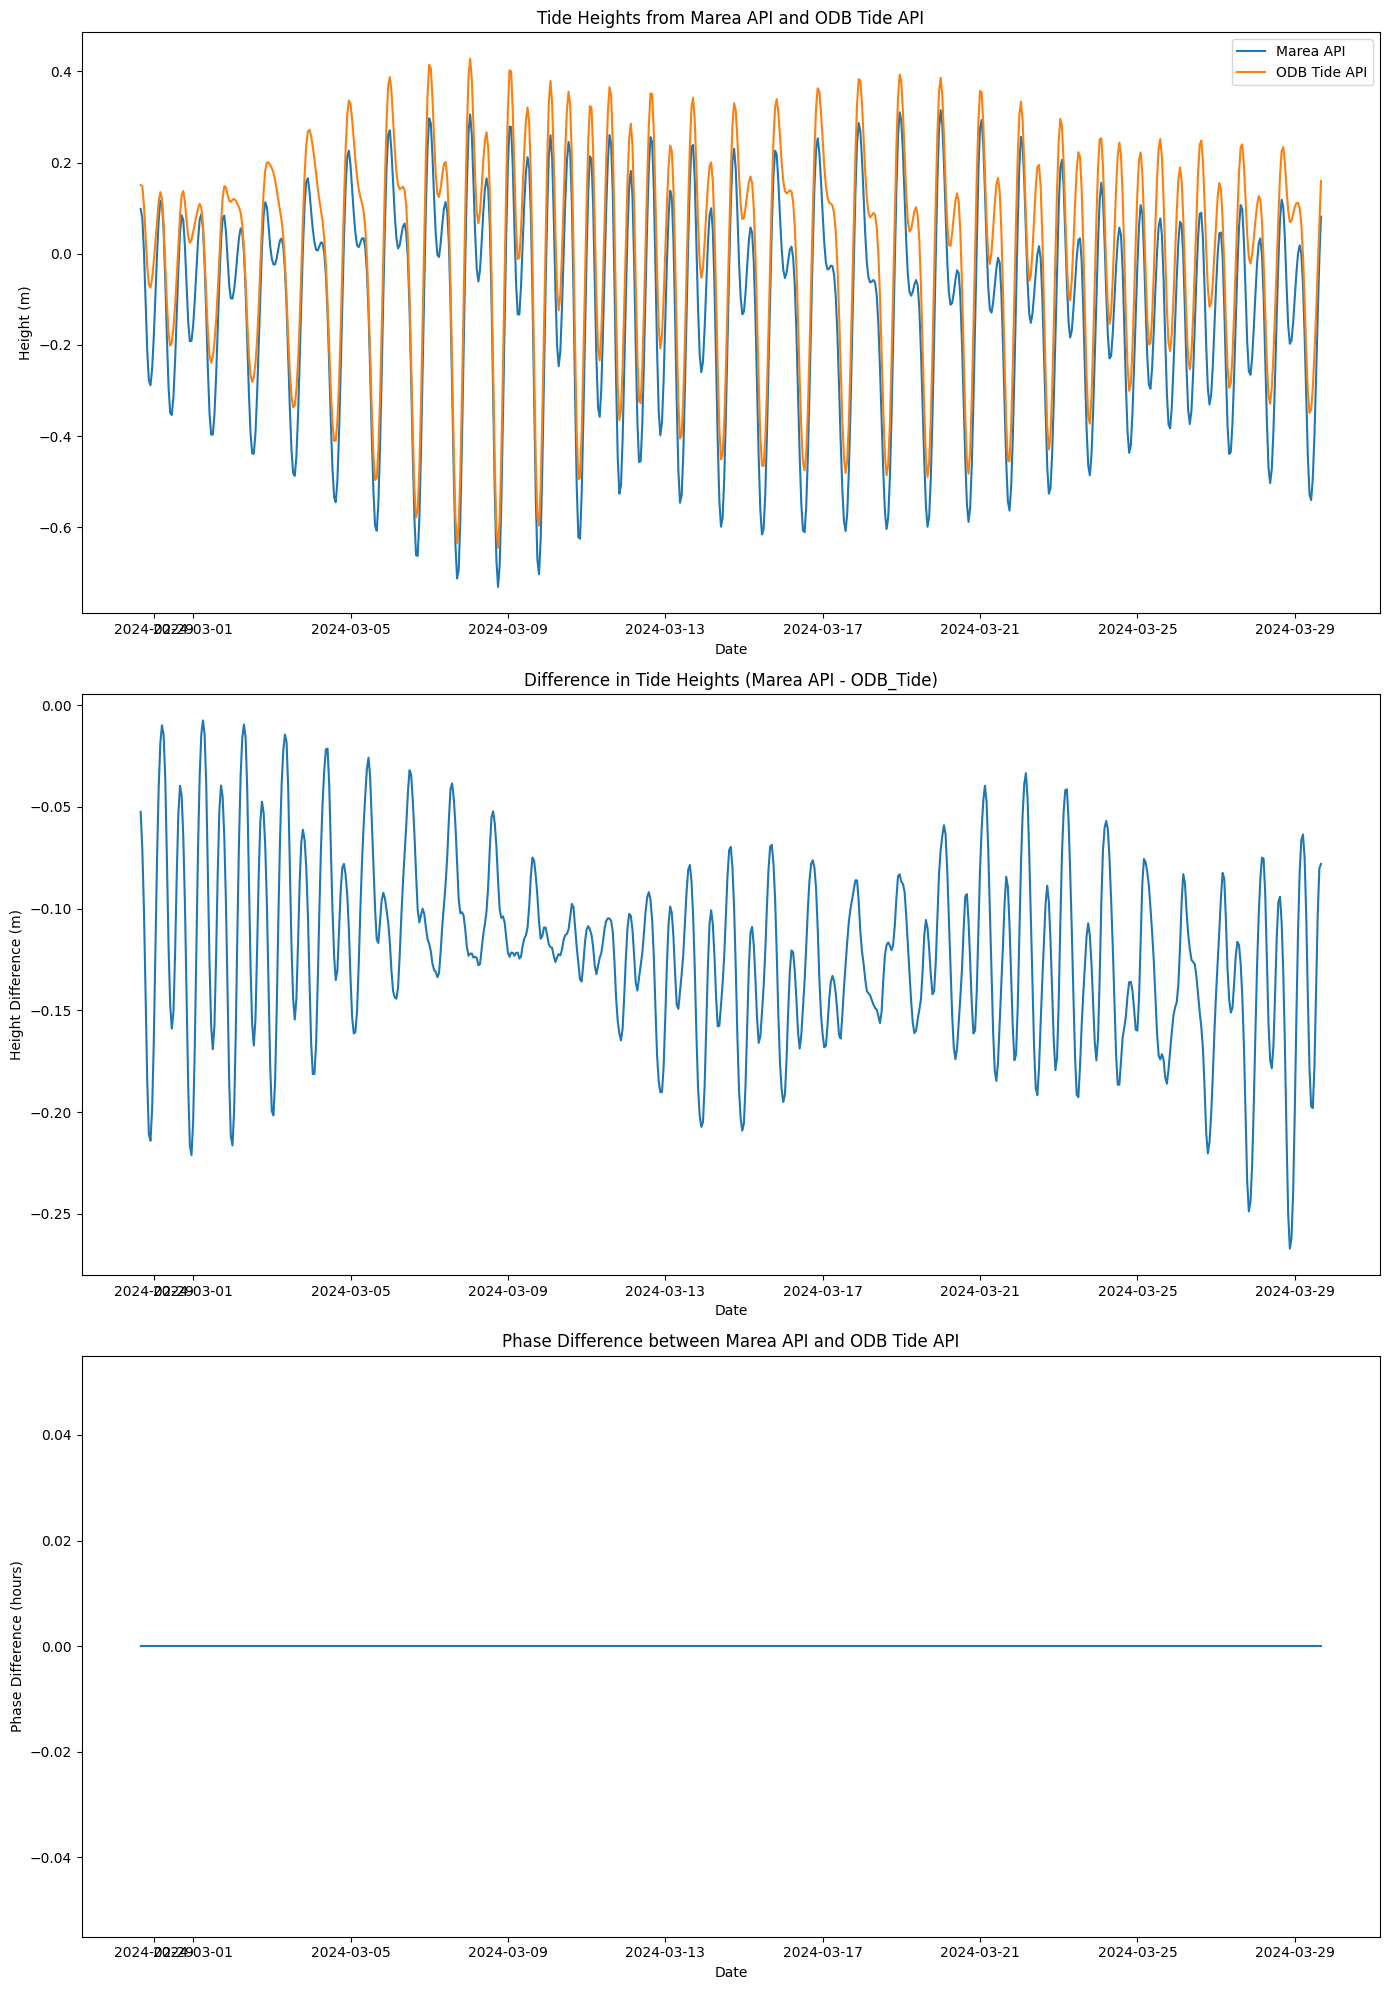

In [126]:
two_tides_compare(comparison_marea, phase_diff_hours, "Marea API")

In [29]:
#Test NOAA stations
lon, lat = -79.923615, 32.780834 #Charleston Harbor PORTS
# Tested stations
#-88.0750, 30.2500 #Dauphin Island #-93.8418, 29.6893 Texas Point, Sabine Pass -97.2735, 27.8804 La Quinta Ch. North #-94.985, 29.681667 Morgans Point #-93.8817, 29.9800 Rainbow Bridge #-93.93, 29.8667 Port Arthur #-146.362, 61.125 #Valdez #-96.6098, 28.6506 Port Lavaca #-149.8904, 61.2375 Anchorage #-80.1618, 25.7314 for Virginia Key, Biscayne Bay #-96.3301, 28.4269 Matagorda Bay Entrance Channel #-97.0391, 27.8366 for Aransas Pass #-70.67111, 41.523613 #Woods Hole
station_timezone = find_timezone(lon, lat)
print(station_timezone)

America/New_York


In [5]:
# Its wrong code that always use exception to convert to utc time
def local_to_utcx(local_datetime, local_timezone='Asia/Taipei', tz=timezone.utc, format="%Y-%m-%dT%H:%M:%S%z"):
    # Handle both naive and aware datetime strings
    try:
        print('Use local timezone:', local_timezone)
        #local_dt = datetime.strptime(local_datetime, "%Y-%m-%dT%H:%M:%S")  # Parse as naive datetime
        #print('Use local dt 1:', local_dt)
        local_tz = pytz.timezone(local_timezone)
        #local_dt = local_tz.localize(local_dt)  # Localize naive datetime
        local_dt = local_tz.localize(datetime.strptime(local_datetime, format))    
        print('Use local dt:', local_dt)
    except ValueError:
        local_dt = datetime.strptime(local_datetime, format)  # Try to parse as aware datetime
        print('Use local dt exception:', local_dt)
    utc_dt = local_dt.astimezone(tz)
    return utc_dt.strftime('%Y-%m-%dT%H:%M:%S')

In [30]:
print(station_timezone)
utctime = local_to_utcx("2024-08-05 00:00", local_timezone=station_timezone, tz=timezone.utc, format="%Y-%m-%d %H:%M")
print(utctime)

America/New_York
Use local timezone: America/New_York
Use local dt: 2024-08-05 00:00:00-04:00
2024-08-05T04:00:00


In [31]:
def extract_noaa_heights(noaa_data, local_timezone):
    print(local_timezone)
    station_id = noaa_data["metadata"]["id"]
    lon = float(noaa_data["metadata"]["lon"])
    lat = float(noaa_data["metadata"]["lat"])
    heights = []
    for record in noaa_data["data"]:
        if record["v"] == '' or record["v"] is None:
            break  # Stop processing the current time series if a missing value is encountered
        dt_utc = local_to_utc(record["t"], local_timezone=local_timezone, format="%Y-%m-%d %H:%M")
        height = float(record["v"])
        heights.append({"station_id": station_id, "longitude": lon, "latitude": lat, "timestamp_utc": dt_utc, "height": height})
    heights_df = pd.DataFrame(heights)
    heights_df["timestamp_utc"] = pd.to_datetime(heights_df["timestamp_utc"])
    return heights_df

In [32]:
# Test NOAA
if True:
    noaa_file_path = 'test_noaa03_8665530.json' #Charleston Harbor PORTS
    #Tested stations
    #Actural phase difference: 8551910 #Chesapeake Bay North PORTS #8665530 #Charleston Harbor PORTS
    #8764314 #Morgan City PORTS #8726674 #Tampa Bay PORTS #8735180 #Dauphin Island #8770822 Texas Point, Sabine Pass #8775132 La Quinta Ch. North #8770613 Morgans Point #8770520 Rainbow Bridge #8770475 Port Arthur #9454240 Valdez #8773259 for Port Lavaca #9455920 Anchorage #8723214 Virginia Key, Biscayne Bay #8773767 Matagorda Bay Entrance Channel #8775241 for Aransas Pass #8447930 #Woods Hole
    noaa_data = read_cwa_data(noaa_file_path)
    target_heights = extract_noaa_heights(noaa_data, station_timezone)
    print("target_heights: ", target_heights)
    # Determine the min/max timestamps from CWA data
    start_utc = target_heights["timestamp_utc"].min().strftime('%Y-%m-%dT%H:%M:%S')
    end_utc = (target_heights["timestamp_utc"].max() + timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%S')
    tide_data = fetch_tide_data(lon, lat, start_utc, end_utc)
    
    # Extract heights from Tide API
    tide_times = pd.to_datetime(tide_data["time"])
    tide_heights = np.array(tide_data["z"]) / 100  # Convert cm to m
    tide_df = pd.DataFrame({"timestamp": tide_times, "height": tide_heights})

America/New_York
target_heights:      station_id  longitude  latitude       timestamp_utc  height
0      8665530   -79.9236   32.7808 2024-08-05 04:00:00   0.207
1      8665530   -79.9236   32.7808 2024-08-05 04:06:00   0.174
2      8665530   -79.9236   32.7808 2024-08-05 04:12:00   0.161
3      8665530   -79.9236   32.7808 2024-08-05 04:18:00   0.151
4      8665530   -79.9236   32.7808 2024-08-05 04:24:00   0.148
..         ...        ...       ...                 ...     ...
278    8665530   -79.9236   32.7808 2024-08-06 07:48:00  -0.248
279    8665530   -79.9236   32.7808 2024-08-06 07:54:00  -0.275
280    8665530   -79.9236   32.7808 2024-08-06 08:00:00  -0.285
281    8665530   -79.9236   32.7808 2024-08-06 08:06:00  -0.282
282    8665530   -79.9236   32.7808 2024-08-06 08:12:00  -0.279

[283 rows x 5 columns]


In [18]:
if True:
    cwa_file_path = 'test_cwa01_1956.json' #C4J01 #C4Q02 with phase-lag #C4B01, phase-diff result is 0
    cwa_data = read_cwa_data(cwa_file_path)
    cwa_heights = extract_cwa_heights(cwa_data)
    
    # Determine the min/max timestamps from CWA data
    min_timestamp = cwa_heights["timestamp_utc"].min()
    max_timestamp = cwa_heights["timestamp_utc"].max()
    
    # Convert min/max timestamps to UTC for ODB Tide API
    start_utc = min_timestamp.strftime('%Y-%m-%dT%H:%M:%S')
    end_utc = (max_timestamp + timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%S')  # Ensure complete coverage
    
    # Fetch Tide API data
    lon, lat = 118.4267, 24.4075 #120.1375, 23.6186 for C4J01 #120.4383, 22.4651 for C4Q02 #121.7522, 25.1550 #for C4B01
    tide_data = fetch_tide_data(lon, lat, start_utc, end_utc)
    
    # Extract heights from Tide API
    tide_times = pd.to_datetime(tide_data["time"])
    tide_heights = np.array(tide_data["z"]) / 100  # Convert cm to m
    tide_df = pd.DataFrame({"timestamp": tide_times, "height": tide_heights})
    
target_heights = cwa_heights

In [33]:
if True:
    # Filter and compare data
    comparison_target = filter_and_compare(target_heights, tide_df)
    
    # Calculate phase difference in minutes
    phase_diff_target_mins = calculate_phase_difference(comparison_target['height_target'], comparison_target['height_tide'])
    phase_diff_target_hrs = phase_diff_target_mins / 60
print(phase_diff_target_hrs)        

0.06666666666666667


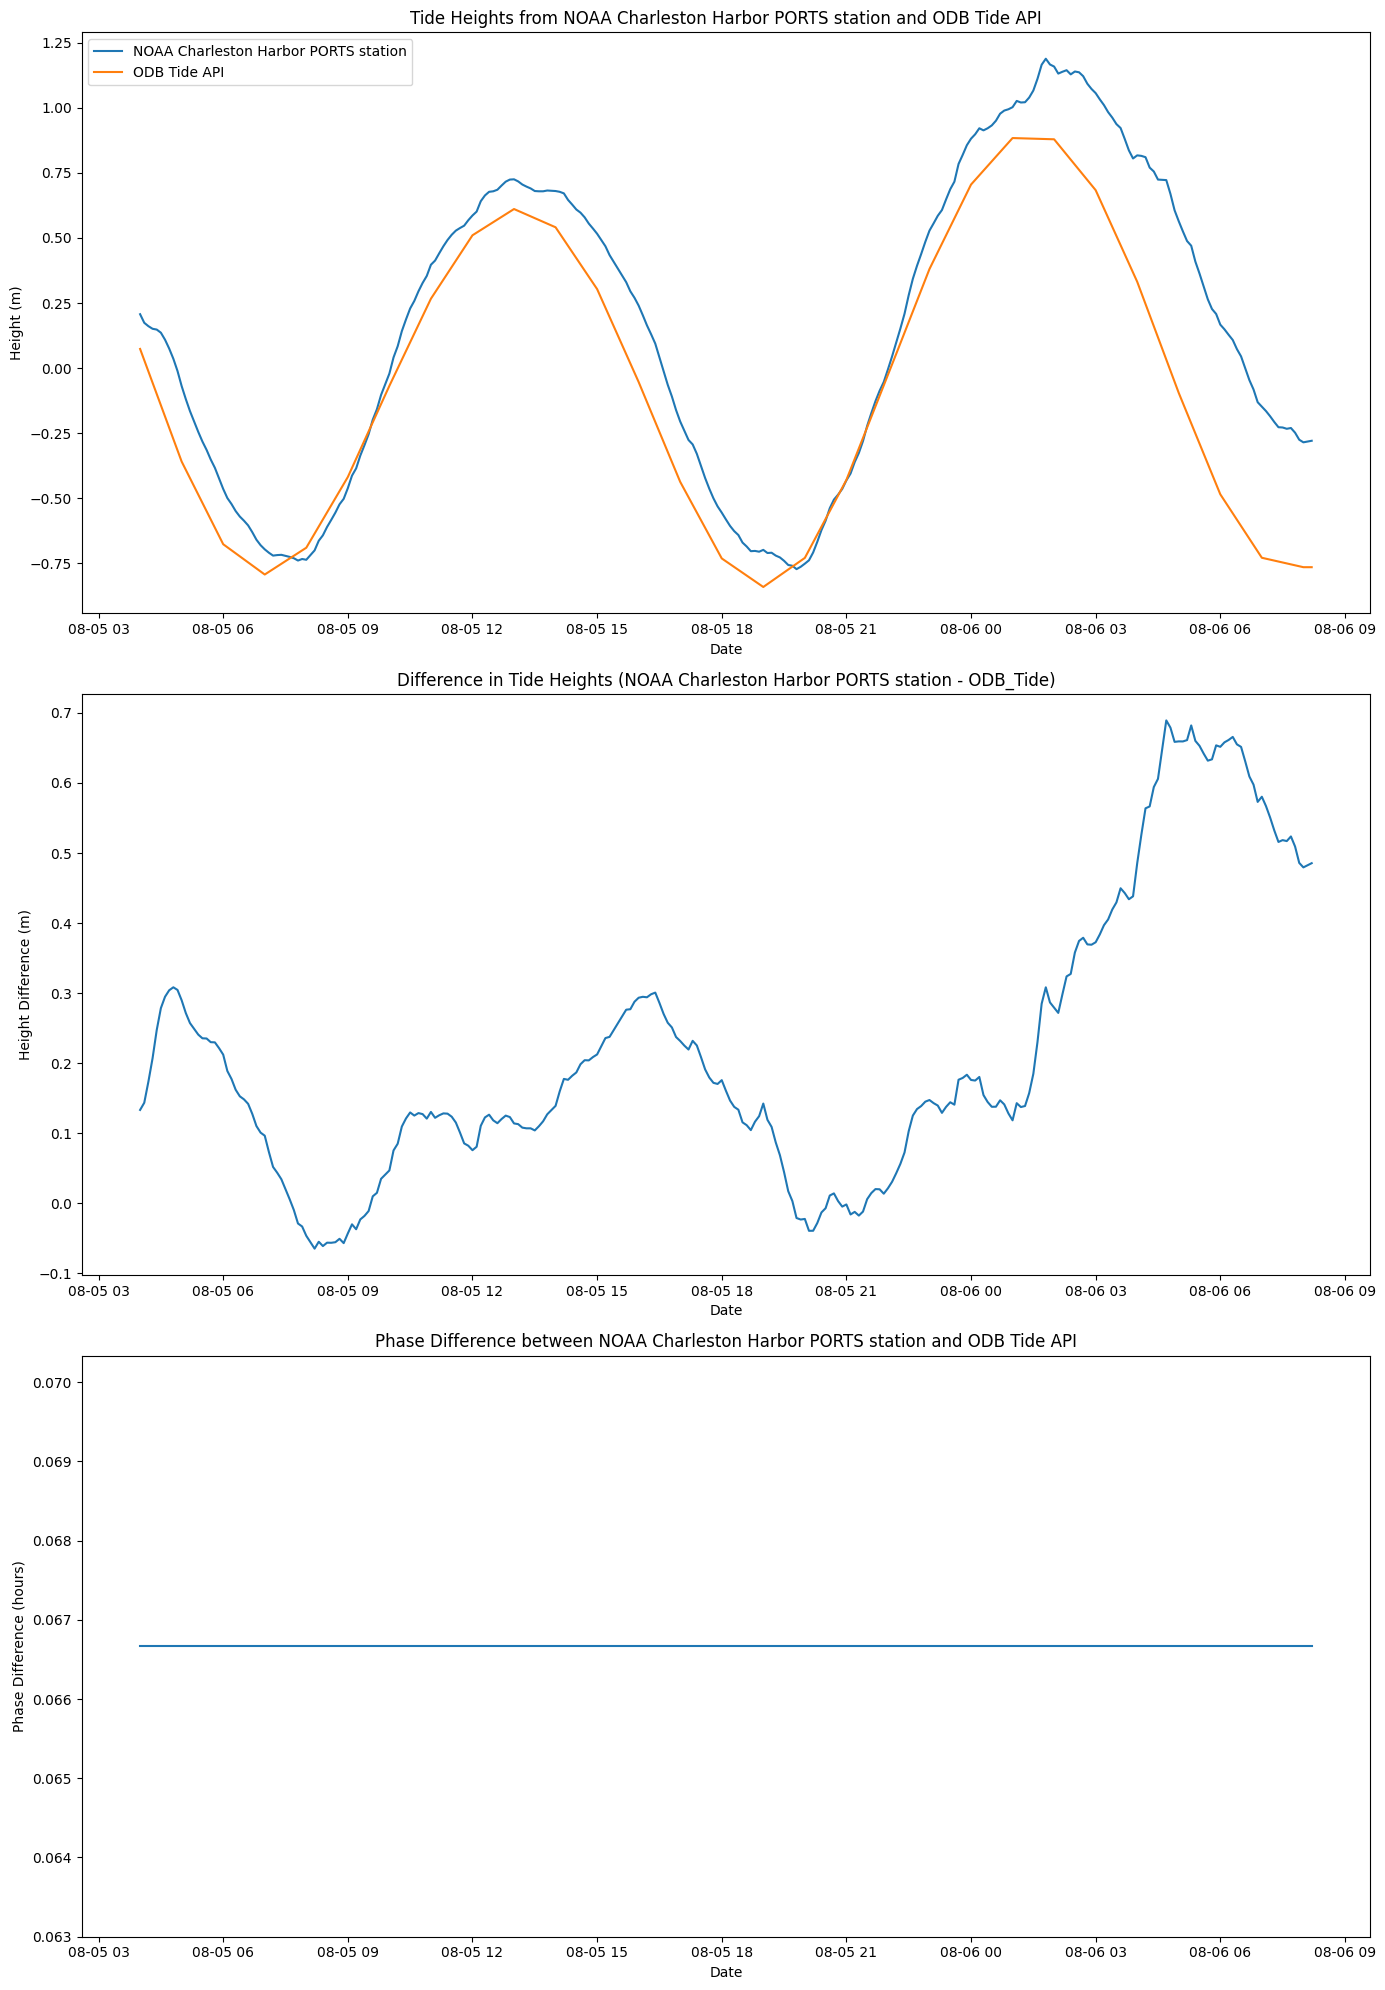

In [34]:
two_tides_compare(comparison_target, phase_diff_target_hrs, "NOAA Charleston Harbor PORTS station") #"CWA Keelung Station")

In [205]:
# Plot amplitude and phase difference statistics
def plot_statistics(station_stats):
    station_names = [stat['station_id'] for stat in station_stats]
    amp_diffs = [stat['amp_diff_mean'] for stat in station_stats]
    phase_diffs = [stat['phase_diff_hours'] for stat in station_stats]
    
    plt.figure(figsize=(14, 7))
    
    # Scatter plot of amplitude differences
    plt.subplot(1, 2, 1)
    plt.scatter(station_names, amp_diffs)
    plt.xlabel("Station ID")
    plt.ylabel("Mean Amplitude Difference (m)")
    plt.title("Mean Amplitude Difference for Each Station")
    plt.xticks(rotation=90)
    
    # Scatter plot of phase differences
    plt.subplot(1, 2, 2)
    plt.scatter(station_names, phase_diffs)
    plt.xlabel("Station ID")
    plt.ylabel("Phase Difference (hours)")
    plt.title("Phase Difference for Each Station")
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

In [133]:
Number_of_Testing = 10
if True:
    # Load station data
    stations_file_path = 'stations_cwa.json'
    with open(stations_file_path, 'r') as file:
        stations_data = json.load(file)
    
    # Randomly select 20 stations
    stations = stations_data["cwaopendata"]["Resources"]["Resource"]["Data"]["SeaSurfaceObs"]["Location"]
    selected_stations = random.sample(stations, Number_of_Testing)
    station = selected_stations[0]
    station_id = station["Station"]["StationID"]
    station_name = station["Station"]["StationName"]
    lon = float(station["Station"]["StationLongitude"])
    lat = float(station["Station"]["StationLatitude"])
print(selected_stations)
print(station_id, station_name, lon, lat)    

[{'Station': {'StationID': '1456', 'StationName': '麥寮', 'StationNameEN': 'Mailiao', 'StationLongitude': '120.1603', 'StationLatitude': '23.7861', 'StationAttribute': '潮位站', 'StationAttributeEN': 'Tidal Station', 'StationAddress': '雲林縣新興海堤及後安寮海堤外側，臺塑六輕麥寮專用港西防波堤', 'StationAddressEN': None, 'County': {'CountyName': '雲林縣', 'CountyNameEN': 'Yunlin County'}, 'Town': {'TownName': '麥寮鄉', 'TownNameEN': 'Mailiao Township'}, 'Area': {'AreaName': '鹿港東石沿海', 'AreaNameEN': 'Lugang-Dongshi inshore'}, 'StationChargeIns': '經濟部水利署', 'StationChargeInsEN': 'Water Resources Agency of Ministry of Economic Affairs'}, 'Description': None, 'Sequence': '0', 'StationObsStatus': {'StationStatus': '1', 'ObservedPropertyNames': 'TideHeight,TideLevel,', 'ObservedProperties': {'TideHeight': {'ObsStatus': '1'}, 'TideLevel': {'ObsStatus': '1'}, 'WindSpeed': {'ObsStatus': '0'}, 'WindScale': {'ObsStatus': '0'}, 'WindDirection': {'ObsStatus': '0'}, 'WindDirectionDescription': {'ObsStatus': '0'}, 'MaximumWindSpeed': {'ObsSt

In [146]:
def main_batch(stations):
    # Load station data
    #stations_file_path = 'stations_cwa.json'
    #with open(stations_file_path, 'r') as file:
    #    stations_data = json.load(file)
    
    # Randomly select 20 stations
    # stations = stations_data["cwaopendata"]["Resources"]["Resource"]["Data"]["SeaSurfaceObs"]["Location"]
    # selected_stations = random.sample(stations, Number_of_Testing)
    
    station_stats = []

    # Iterate over selected stations
    for station in stations:
        station_id = station["Station"]["StationID"]
        station_name = station["Station"]["StationName"]
        lon = float(station["Station"]["StationLongitude"])
        lat = float(station["Station"]["StationLatitude"])
        
        # Set up time range (last 24 hours from now)
        now = datetime.now(timezone.utc) - timedelta(1) + timedelta(hours=8)  # Convert to local GMT+8 time
        start_gmt8 = now.replace(hour=0, minute=0, second=0, microsecond=0)
        end_gmt8 = start_gmt8 + timedelta(days=1)
        
        start_utc = start_gmt8 - timedelta(hours=8)
        end_utc = end_gmt8 - timedelta(hours=8)

        start_utc_str = start_utc.strftime('%Y-%m-%dT%H:%M:%S')
        end_utc_str = end_utc.strftime('%Y-%m-%dT%H:%M:%S')
        start_gmt8_str = start_gmt8.strftime('%Y-%m-%dT%H:%M:%S')
        print("Test_time: ", start_gmt8_str, end_utc_str)
        
        # Fetch CWA data
        cwa_url = f"https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-B0075-002?Authorization={os.getenv('CWA_TOKEN')}&StationID={station_id}&WeatherElement=TideHeight,TideLevel&sort=DataTime&timeFrom={start_gmt8_str}"
        cwa_response = requests.get(cwa_url)
        cwa_data = cwa_response.json()
        print("Fetch CWA data: ", cwa_data)
        
        if not cwa_data['Records']['SeaSurfaceObs']['Location']:
            continue

        # Extract heights from CWA data
        cwa_heights = extract_cwa_heights(cwa_data)
        
        if cwa_heights.empty:
            continue
        
        # Fetch Tide API data
        tide_data = fetch_tide_data(lon, lat, start_utc_str, end_utc_str)
        
        # Extract heights from Tide API
        tide_times = pd.to_datetime(tide_data["time"])
        tide_heights = np.array(tide_data["z"]) / 100  # Convert cm to m
        tide_df = pd.DataFrame({"timestamp": tide_times, "height": tide_heights})
        
        # Filter and compare data
        comparison_df = filter_and_compare(cwa_heights, tide_df)
        
        # Calculate phase difference in minutes
        phase_diff_minutes = calculate_phase_difference(comparison_df['height_target'], comparison_df['height_tide'])
        phase_diff_hours = phase_diff_minutes / 60
        
        # Collect statistics
        amp_diff_mean = comparison_df["height_diff"].mean()
        amp_diff_std = comparison_df["height_diff"].std()
        
        station_stats.append({
            "station_id": f"{station_id}{station_name}",
            "amp_diff_mean": amp_diff_mean,
            "amp_diff_std": amp_diff_std,
            "phase_diff_hours": phase_diff_hours
        })
        
        # Pause to avoid hitting rate limit
        time.sleep(0.5)
    
    # Plot statistics
    plot_statistics(station_stats)
    return station_stats



In [ ]:
# Execute the batch function
test_stats = main_batch(selected_stations)
print(test_stats)
        